In [1]:
from pathlib import Path

# --- 1. Core Data Handling & System Tools ---
# 'os' is often used for path construction (e.g., reading your CSV from the 'data' folder)
import os 
import numpy as np
import pandas as pd
import scipy as sp # Renaming to 'sp' for generic scientific functions

# For progress bars (tqdm is available)
from tqdm.notebook import tqdm 


# --- 2. Visualization Libraries ---
# All core visualization tools are available
import matplotlib.pyplot as plt
import seaborn as sns


# --- 3. Machine Learning & Modeling (scikit-learn is available) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Metrics are crucial for classification problems like fraud detection
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Import common models you might use (replace/add as needed)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 


# For model interpretability
import shap


In [2]:

# Define project root dynamically
PROJECT_ROOT = Path.cwd().parent if "notebooks" in Path.cwd().parts else Path.cwd()
DATA_PATH = PROJECT_ROOT / "data" / "fraud_detection_dataset.csv"

# Read CSV
fulldf = pd.read_csv(DATA_PATH)
fulldf


,timestamp,user_id,amount,location,device_type,is_fraud,age,income,debt,credit_score
0,2023-12-15 02:48:24,3cbf0b8a-c799-4c0e-9782-89272ab8fa2b,998.99,Grantfurt,Mobile,0,56,42524.98,8394.05,655
1,2023-10-30 11:08:37,3675ed98-6863-4bae-b089-6f0db2df006b,241.39,Kimberlychester,Tablet,0,52,69884.04,28434.06,395
2,2023-11-21 05:19:35,4be1043f-20ee-4ac5-a689-b25c6a1de50c,836.42,Gutierrezville,Desktop,0,58,126953.62,39121.78,496
3,2023-11-07 00:03:25,cad0b3c9-099f-479b-8043-6d5ecb4e1467,612.74,Markside,Desktop,0,19,128650.70,39652.48,612
4,2023-04-02 14:12:23,b6ebea7d-ba62-41d7-b042-3978a23fef8b,135.55,Anthonyshire,Tablet,0,59,102020.39,7439.81,302
...,...,...,...,...,...,...,...,...,...,...
1999995,2023-08-10 09:45:49,9a153a34-12d2-4eb1-a9fb-1eb2026ae0b6,3478.81,Joelview,Desktop,1,20,127482.32,6161.07,796
1999996,2023-10-17 00:32:20,580c1fee-1abe-40bd-b166-fc1ecaf555d4,2337.90,Taylormouth,Mobile,1,22,94866.98,21614.64,660
1999997,2023-05-19 13:17:44,41a22779-882a-4459-a00a-8b29521a8d38,2142.04,Coryview,Mobile,1,51,137229.33,5654.83,432
1999998,2023-10-22 14:07:19,1e3ca371-9b58-4c01-99a2-770c4770716f,2452.60,Escobarfurt,Desktop,1,45,129794.90,34964.36,317


In [3]:
# Data Cleaning


# 1 - Check for Missing Values

null_vals = fulldf.isnull().sum()


# 2 - Date Standarisation 
fulldf['timestamp'] = pd.to_datetime(fulldf['timestamp'], errors='coerce')
int(fulldf['timestamp'].isna().sum()) #as the number is = 0 we can be certain that all dates have been standardised

# 3 - Validation of fraud label
fulldf['is_fraud'].value_counts() # result shows that there are 1,000,000 fraud and 1,000,000 not fraud transactions

# In addition all data types have been validated via the use of fulldf.info
fulldf.dtypes

# No duplicate transaction - validated by creating compound key with timestamp and user_id 
bool(fulldf[['user_id', 'timestamp']].duplicated().any())


False

Text(0.5, 1.0, 'Top Fraud Activity by Location')

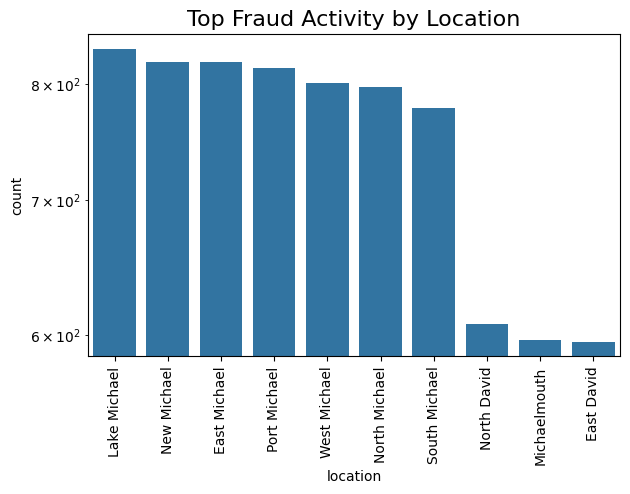

In [4]:
# Univariate analysis 
# Fraud by location

frauddf=fulldf[fulldf['is_fraud']==1]

fraud_by_location = sns.barplot(frauddf['location'].value_counts().head(10), legend=False)
fraud_by_location.set_yscale('log')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.title('Top Fraud Activity by Location', fontsize=16)  # You can adjust fontsize, color, etc.


<Axes: xlabel='amount', ylabel='Density'>

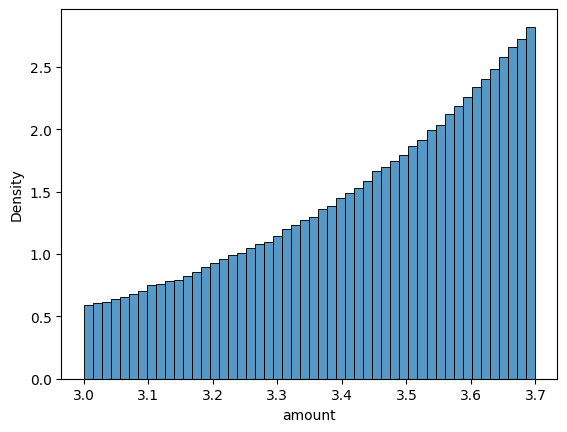

In [5]:
# Distribution of fraud transactions by amount per transaciton
sns.histplot(np.log10(frauddf['amount']),bins=50, stat="density")

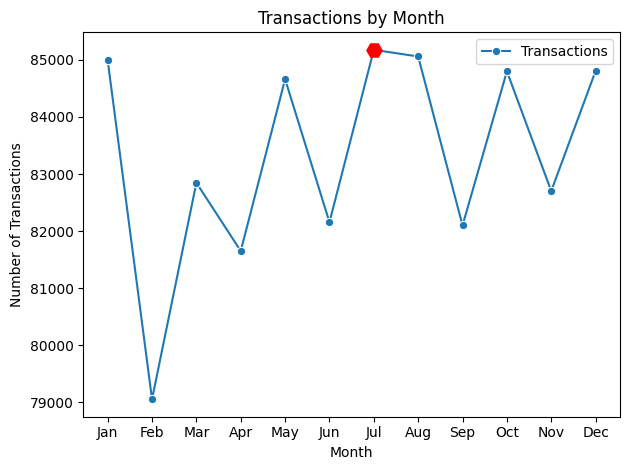

In [6]:
# Aggregate number of transactions by month
fraud_by_month = frauddf.groupby(frauddf['timestamp'].dt.month)['is_fraud'].count().reindex(range(1,13), fill_value=0)

# Identify peak month
peak_month = fraud_by_month.idxmax()
peak_value = fraud_by_month.max()

# Month labels
month_labels = pd.to_datetime(fraud_by_month.index, format='%m').strftime('%b')

# Plot

sns.lineplot(x=fraud_by_month.index, y=fraud_by_month.values, marker='o', label='Transactions')

# Highlight peak month
plt.scatter(peak_month, peak_value, s=120, marker='H', color='red', zorder=5, label='Peak')

plt.xticks(fraud_by_month.index, month_labels)
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.title("Transactions by Month")
plt.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x26b1500b750>,
 [Text(0.0, 0, 'Monday'),
  Text(1.0, 0, 'Tuesday'),
  Text(2.0, 0, 'Wednesday'),
  Text(3.0, 0, 'Thursday'),
  Text(4.0, 0, 'Friday'),
  Text(5.0, 0, 'Saturday'),
  Text(6.0, 0, 'Sunday')])

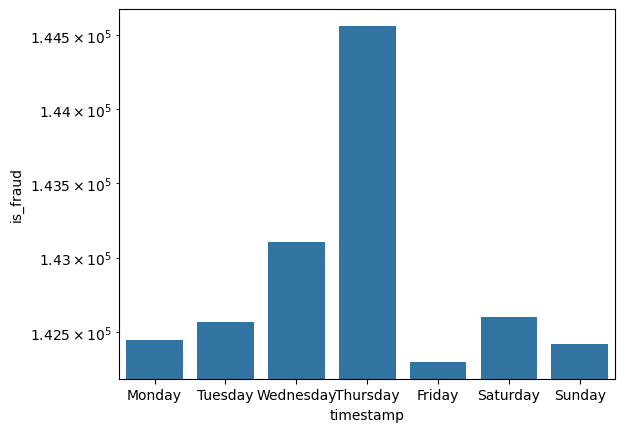

In [7]:
# Aggregate number of transactions by day of week

order = [
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday', 'Sunday'
]
fraud_by_day =  frauddf.groupby(frauddf['timestamp'].dt.day_name())['is_fraud'].count().reindex(order)
fraud_by_day

sns.barplot(fraud_by_day)
plt.yscale('log')  # log scale
plt.xticks(fraud_by_day.index)


Text(0.5, 1.0, 'Fraud per Device Type')

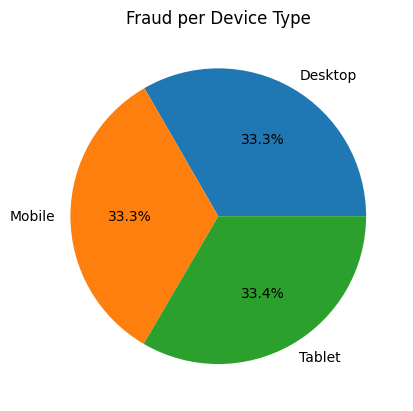

In [8]:
fraud_by_device = frauddf.groupby(frauddf['device_type'])['is_fraud'].count()
plt.pie(fraud_by_device,autopct='%1.1f%%',labels=fraud_by_device.index)
plt.title("Fraud per Device Type")

<Axes: xlabel='income', ylabel='Density'>

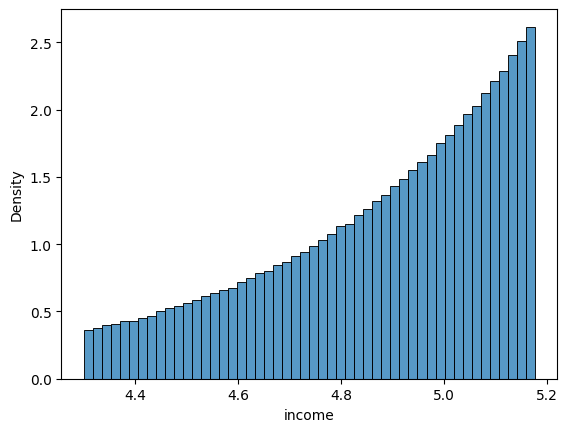

In [9]:
# Distribution of fraud transactions by income
sns.histplot(np.log10(frauddf['income']),bins=50, stat="density")

<Axes: xlabel='debt', ylabel='Density'>

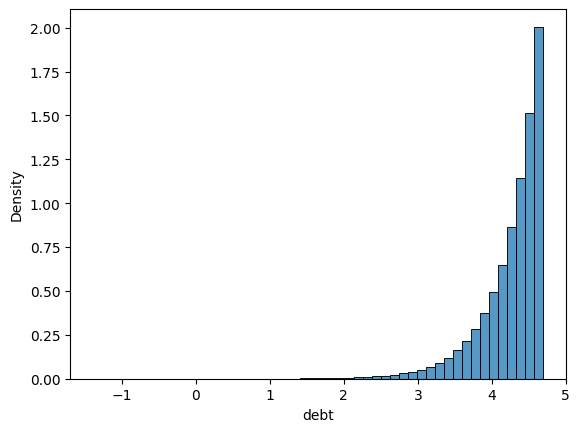

In [10]:
# Distribution of fraud transactions by amount per transaciton
sns.histplot(np.log10(frauddf['debt']),bins=50, stat="density")

In [11]:

# Group by hour and apply day/night
fraud_by_hour = (
    frauddf
    .groupby(frauddf['timestamp'].dt.hour)['is_fraud']
    .count()
    .reset_index(name='fraud_count')
)
fraud_by_hour['is_night'] = np.where(fraud_by_hour['timestamp']>=12, '1', '0')

fraud_by_hour


,timestamp,fraud_count,is_night
0,0,41869,0
1,1,41634,0
2,2,41809,0
3,3,41852,0
4,4,41656,0
5,5,41518,0
6,6,41845,0
7,7,41342,0
8,8,41921,0
9,9,41817,0


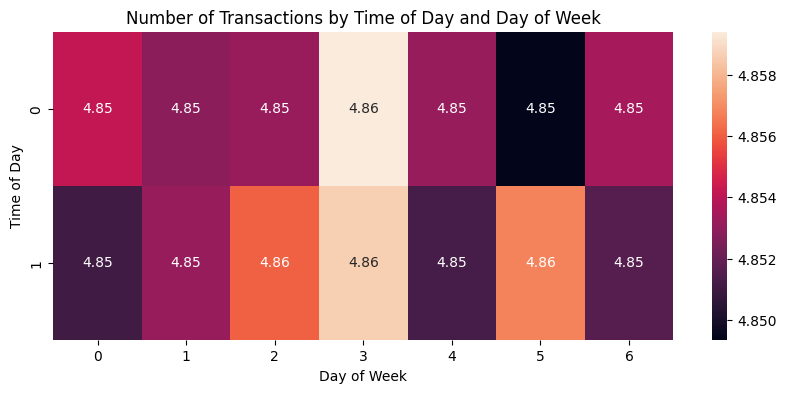

In [12]:
day_v_night_df = frauddf.copy()
day_v_night_df['is_night'] = np.where((day_v_night_df['timestamp'].dt.hour < 6) |
    (day_v_night_df['timestamp'].dt.hour >= 18), '1', '0')
day_v_night_df['day_of_week'] = day_v_night_df['timestamp'].dt.day_of_week
day_v_night_df[['timestamp', 'day_of_week']]

heatmap_df = (
    day_v_night_df
    .groupby(['is_night', 'day_of_week'])
    .size()
    .unstack(fill_value=0)
)

log_heatmap_df = np.log10(heatmap_df + 1)

plt.figure(figsize=(10, 4))
sns.heatmap(
    log_heatmap_df,
    annot=True,
    fmt='.2f'
)

plt.xlabel('Day of Week')
plt.ylabel('Time of Day')
plt.title('Number of Transactions by Time of Day and Day of Week')
plt.show()

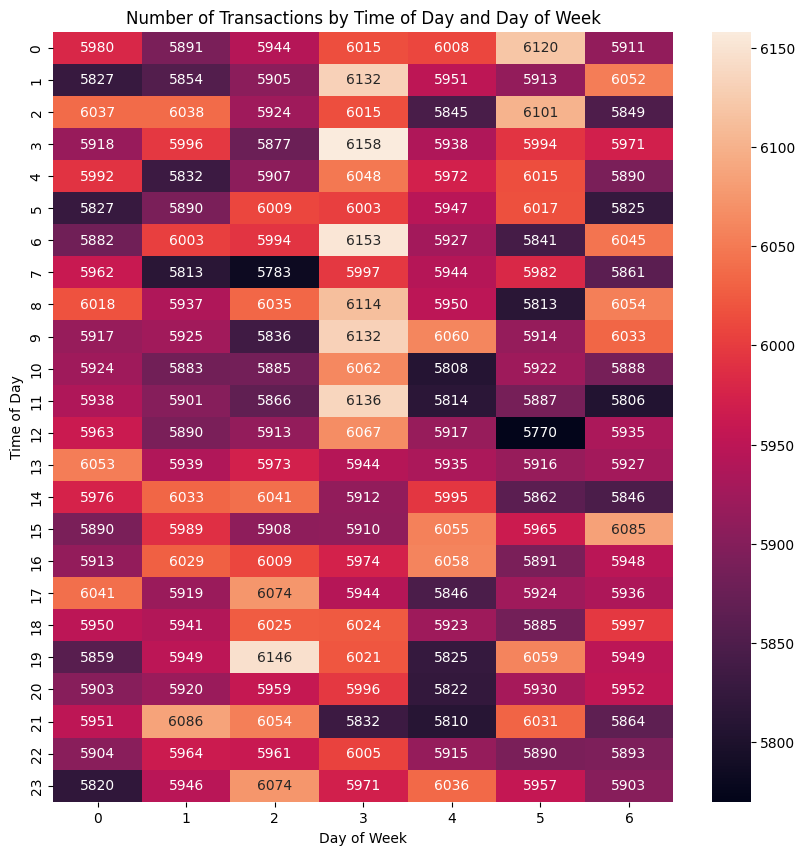

In [13]:
timeofday_df = frauddf.copy()
timeofday_df['hour'] = timeofday_df['timestamp'].dt.hour
timeofday_df['day_of_week'] = timeofday_df['timestamp'].dt.day_of_week


todheatmap_df = (
    timeofday_df
    .groupby(['hour', 'day_of_week'])
    .size()
    .unstack(fill_value=0)
)

todlog_heatmap_df = np.log10(todheatmap_df + 1)

plt.figure(figsize=(10,10))
sns.heatmap(
    todheatmap_df,
    annot=True,
    fmt='d',
    square=False
)

plt.xlabel('Day of Week')
plt.ylabel('Time of Day')
plt.title('Number of Transactions by Time of Day and Day of Week')
plt.show()

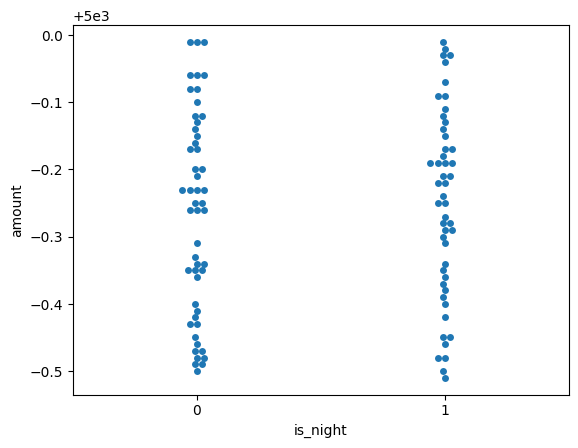

In [14]:

top_100_df = day_v_night_df.nlargest(100, 'amount')
sns.swarmplot(data=top_100_df, x="is_night", y="amount")

plt.show()

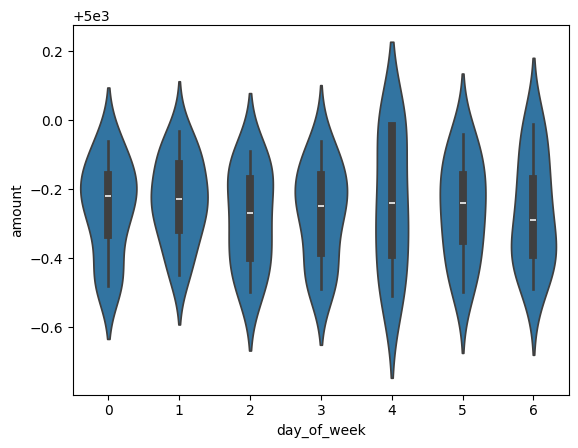

In [15]:

top_100_df_2 = timeofday_df.nlargest(500, 'amount')
sns.violinplot(data=top_100_df, x="day_of_week", y="amount")

plt.show()

C:\Users\aashi\AppData\Local\Temp\ipykernel_20964\687763155.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(sequential_bins, rotation=90)


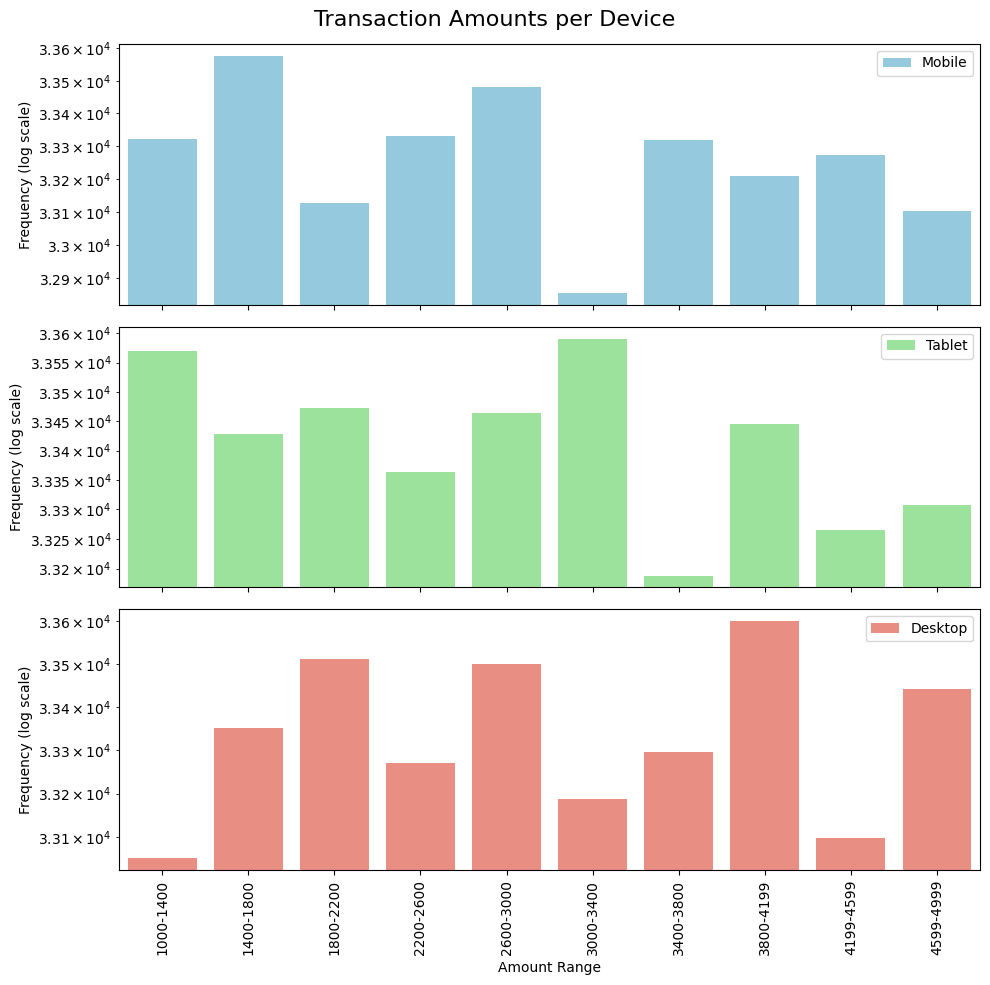

In [16]:
# Filter by device type
device_types = ["Mobile", "Tablet", "Desktop"]
device_colors = ["skyblue", "lightgreen", "salmon"]
bins = 10

# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))  # taller figure

for i, device in enumerate(device_types):
    device_fraud = frauddf[frauddf["device_type"] == device]
    
    counts, bin_edges = np.histogram(device_fraud['amount'], bins=bins)
    
    # Sequential bin labels
    sequential_bins = [f"{int(bin_edges[j])}-{int(bin_edges[j+1])}" for j in range(bins)]
    
    # Plot on the corresponding subplot
    sns.barplot(x=sequential_bins, y=counts, color=device_colors[i],label=device, ax=axes[i])
    axes[i].set_yscale('log')
    if i < 2:
        axes[i].set_xticklabels([])
        axes[i].set_xlabel('')
    else:
        axes[i].set_xticklabels(sequential_bins, rotation=90)
        axes[i].set_xlabel('Amount Range')
    axes[i].set_ylabel('Frequency (log scale)')
    
fig.suptitle('Transaction Amounts per Device', fontsize=16)


plt.tight_layout()
plt.show()

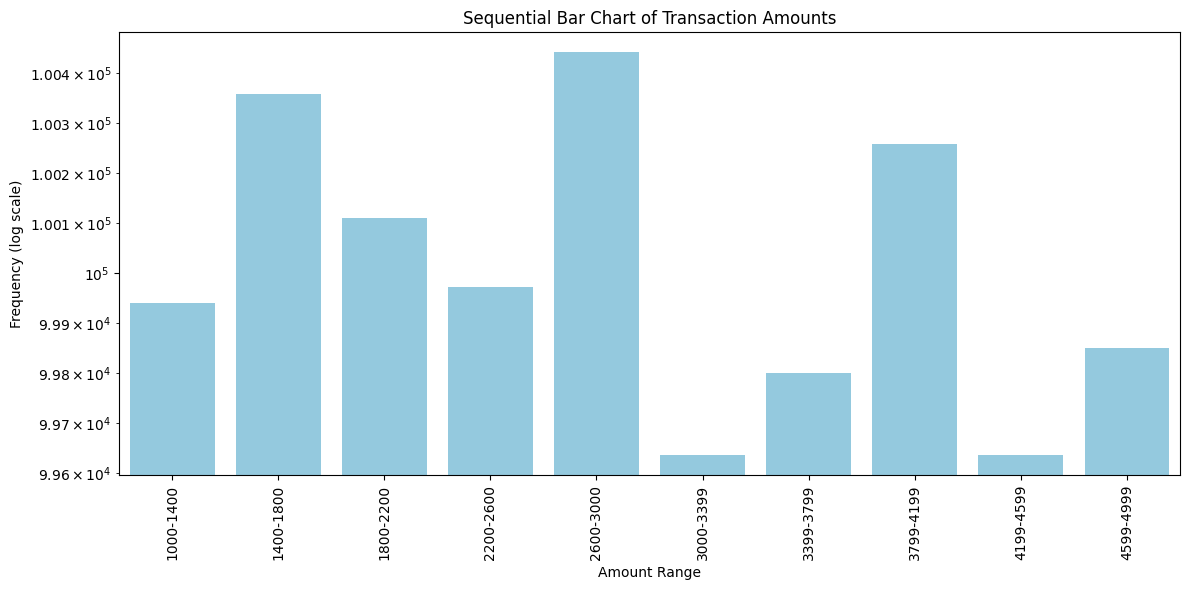

In [17]:
bins = 10
counts, bin_edges = np.histogram(frauddf['amount'], bins=bins)

# CREATE SEQUENTIAL LABELS (using the original bin_edges)
# We loop from the first bin edge (i=0) up to the second-to-last (i=bins-1)
sequential_bins = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(bins)]

# Plot as barplot
plt.figure(figsize=(12,6))
# Use the unsorted 'sequential_bins' for x and 'counts' for y
sns.barplot(x=sequential_bins, y=counts, color='skyblue')
plt.yscale('log')  # log scale
plt.xticks(rotation=90)
plt.xlabel('Amount Range')
plt.ylabel('Frequency (log scale)')
plt.title('Sequential Bar Chart of Transaction Amounts')
plt.tight_layout()
plt.show()